## Image Obfuscation with Pseudonymization
In this notebook we are exploring how to replace entities like names, ids, or addresses by pseudonyms, this is, similar entities of the same class. But we won't stop there, we will also render these fake entities on top of the original images creating a new "impainted" version of the documents.</br>
In order for that to happen successfully, we not only need to pick replacementes from the same class, i.e., names, addresses, etc, but also we need to find replacements that render in a similar manner in the page. Also, the pipeline we will show today will make its best to keep font size consistency between the replacement texts and the surrounding context.</br> 
Let's jump into it!

## Install spark-ocr python package
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar`
- or `secret` for Spark OCR
- `aws_access_key` and `aws_secret_key`for download pretrained models

In [1]:
license = ""
secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12"

In [3]:
from sparkocr import start
import os
import sys

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key

nlp_secret = ""


spark = start(secret=secret,
              jar_path=spark_ocr_jar_path, nlp_internal="5.5.2", nlp_secret=nlp_secret)

spark

Spark version: 3.4.1
Spark NLP version: 5.5.2
Spark NLP for Healthcare version: 5.5.2
Spark OCR version: 5.5.0



In [4]:
import numpy as np
import os
import gdown

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
import sparkocr
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, to_pil_image, display_images_horizontal
from sparkocr.metrics import score
import pkg_resources

# import sparknlp packages
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

In [5]:
from sparknlp.pretrained import PretrainedPipeline

deid_pipeline = PretrainedPipeline("ner_deid_subentity_context_augmented_pipeline", "en", "clinical/models")
stages = deid_pipeline.model.stages

pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setKeepInput(True) \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
    .setWithSpaces(True) \
    .setConfidenceThreshold(70)


stages.insert(0,pdf_to_image)
stages.insert(1,ocr)

custom_ner_converter_internal = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_subentity"]) \
        .setOutputCol("ner_chunk_subentity") \
        .setThreshold(0.6) \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PERSON', 'DATE', 'IDNUM', 'DOCTOR', 'PATIENT', 'MEDICALRECORD', 'PHONE', 'CITY','ZIP'])

stages[7] = custom_ner_converter_internal

deid_obfuscated = DeIdentification()\
    .setInputCols(["sentence", "token", "ner_chunk"]) \
    .setOutputCol("obfuscated") \
    .setMode("obfuscate") \
    .setKeepMonth(True) \
    .setKeepYear(True) \
    .setObfuscateDate(True)\
    .setReturnEntityMappings(True) \
    .setKeepTextSizeForObfuscation(True) \
    .setFakerLengthOffset(10) \
    .setMappingsColumn("aux") \
    .setIgnoreRegex(True) \
    .setSeed(40) \
    .setConsistentObfuscation(True) \
    .setDateFormats(["yyyy"])


position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setOcrScaleFactor(0.9)


drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputChunkMappingCol("aux") \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setPatchImages(True) \
    .setUseContrastTextColor(False) \
    .setPageMatrixCol("positions")


stages.append(deid_obfuscated)
stages.append(position_finder)
stages.append(drawRegions)

new_pipe = Pipeline(stages=stages)

ner_deid_subentity_context_augmented_pipeline download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [6]:
df = spark.read.format("binaryFile").load("./pdfs/mock_doc.pdf")

result = new_pipe.fit(df).transform(df).cache()

## Visualize Input Data & Output Data


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/pdfs/mock_doc.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


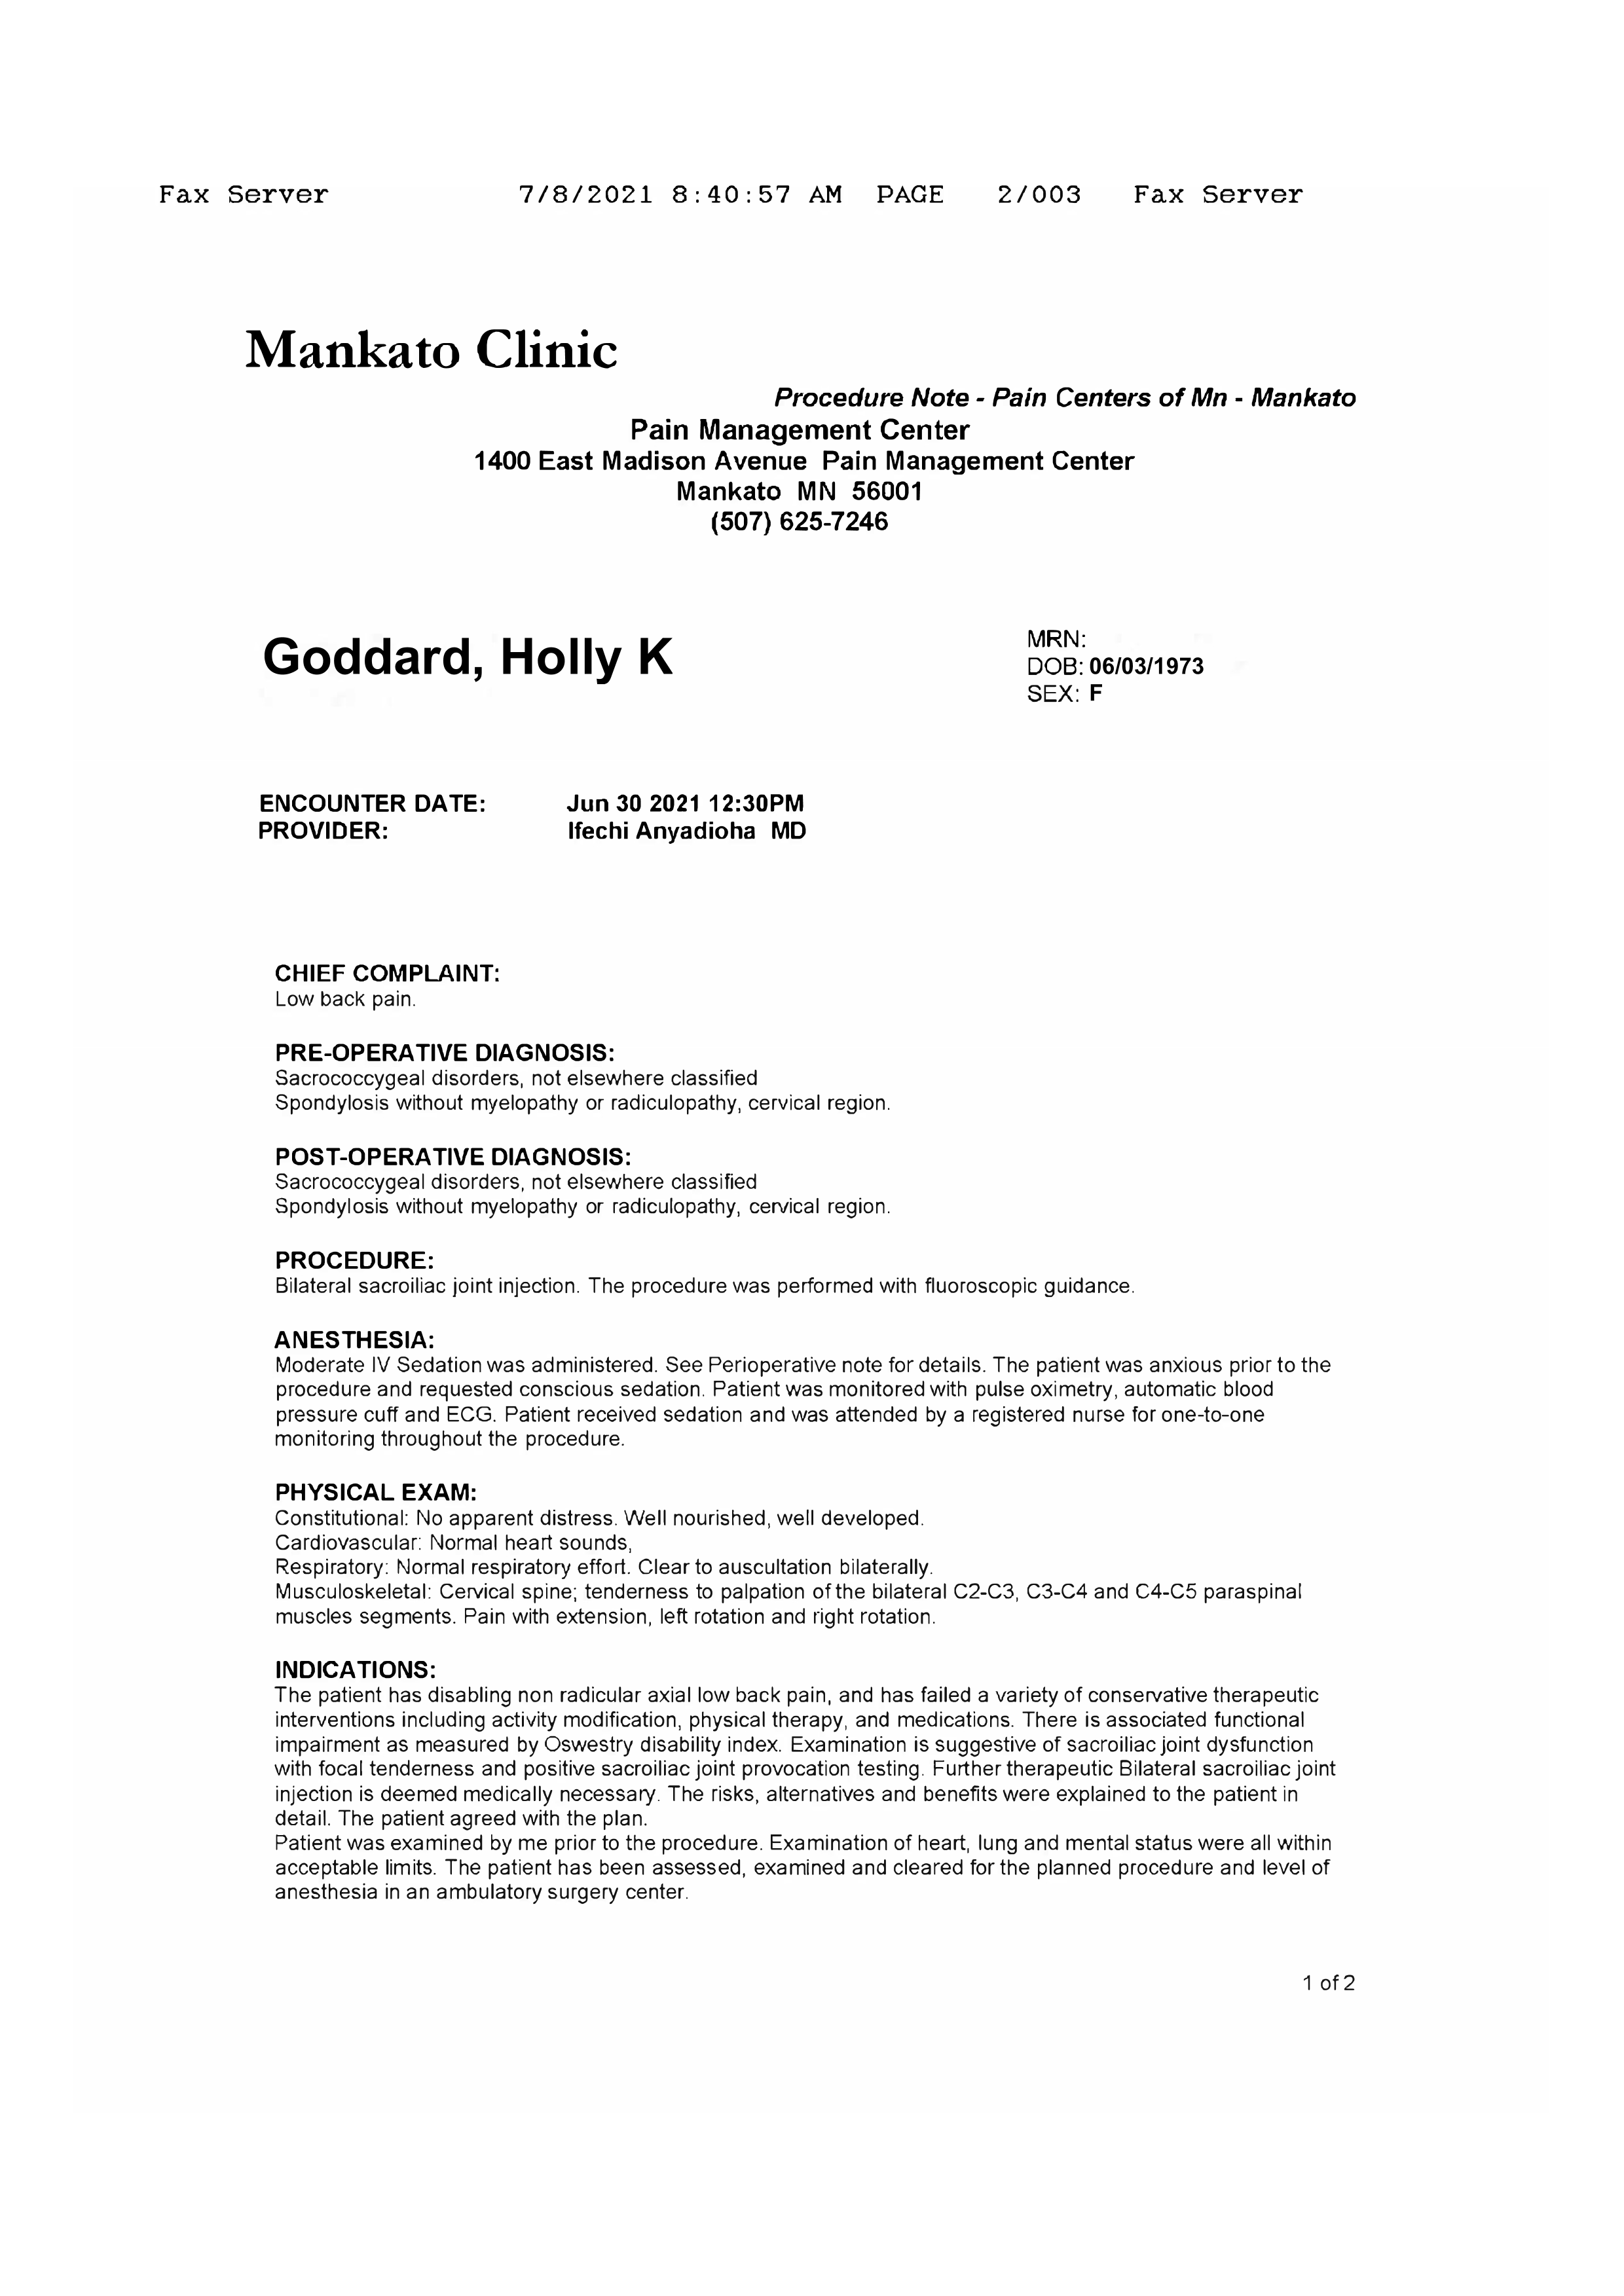

In [7]:
display_images(result, "image_raw")


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/pdfs/mock_doc.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


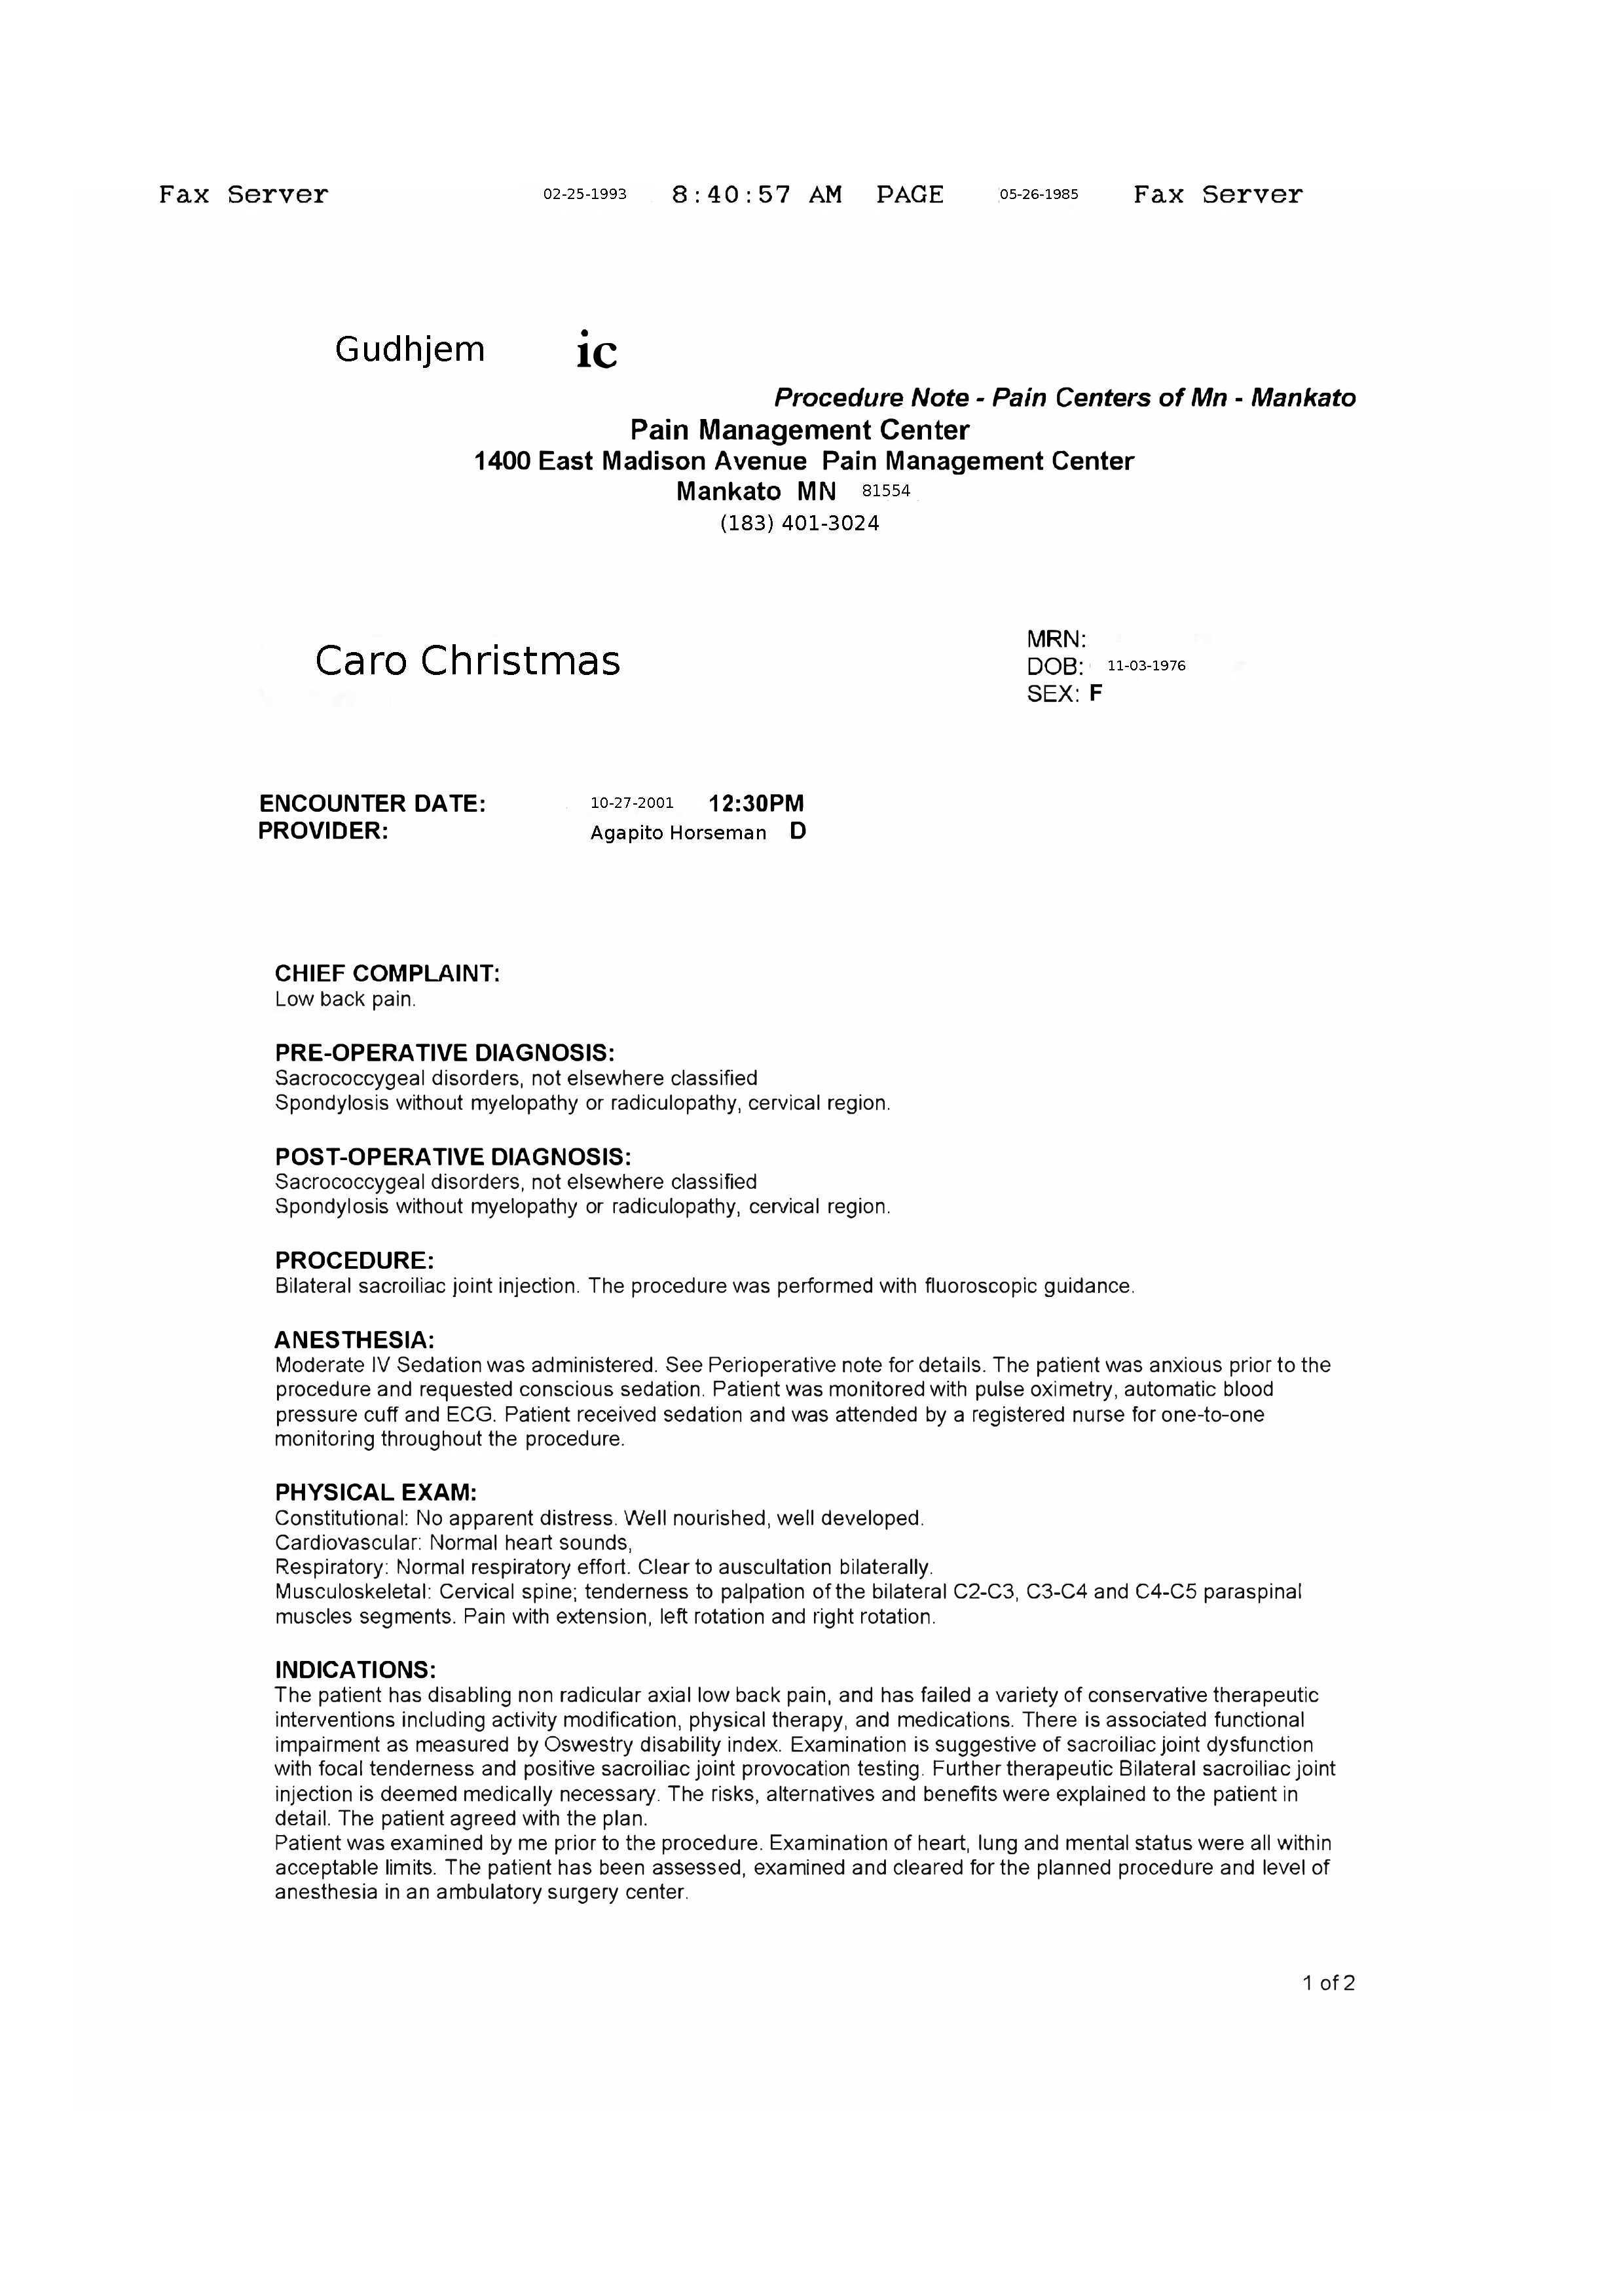

In [9]:
display_images(result, "image_with_regions")

## List all replacements
In the following cell we will take a look at the original entities and the obfuscated versions together with their lengths.

In [10]:
for item in result.select("aux").collect()[0].asDict()["aux"]:
    data = item.asDict()

    orig = data["metadata"]["originalChunk"]
    res = data["result"]
    
    print(f"Original: {orig} Original Length: {len(orig)} Obfuscated: {res} Obfuscated Length: {len(res)}", end="\n\n")

Original: 7/8/2021 Original Length: 8 Obfuscated: 02-25-1993 Obfuscated Length: 10

Original: 2/003 Original Length: 5 Obfuscated: 05-26-1985 Obfuscated Length: 10

Original: Mankato Original Length: 7 Obfuscated: Gudhjem Obfuscated Length: 7

Original: 56001 Original Length: 5 Obfuscated: 81554 Obfuscated Length: 5

Original: (507) 625-7246 Original Length: 14 Obfuscated: (183) 401-3024 Obfuscated Length: 14

Original: Goddard, Holly Original Length: 14 Obfuscated: Caro Christmas Obfuscated Length: 14

Original: 06/03/1973 Original Length: 10 Obfuscated: 11-03-1976 Obfuscated Length: 10

Original: Jun 30 2021 Original Length: 11 Obfuscated: 10-27-2001 Obfuscated Length: 10

Original: Ifechi Anyadioha Original Length: 16 Obfuscated: Agapito Horseman Obfuscated Length: 16

